In [ ]:
# Install cztile and dependencies
! pip install --upgrade pip
! pip install "cztile>=0.0,<0.1" matplotlib tqdm scikit-image pooch requests numpy

# cztile - Tutorial

This notebook demonstrates how to use **[cztile](https://pypi.org/project/cztile/)** to tile an image.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from skimage.filters import gaussian
from tqdm import tqdm
import random
import os
from skimage.io import imread

# import the "tiling strategy" from the cztile package
from cztile.fixed_total_area_strategy import AlmostEqualBorderFixedTotalAreaStrategy2D
from cztile.tiling_strategy import Rectangle as czrect

## Define parameters for data loading

In [ ]:
# Folder containing the input data
INPUT_FOLDER = 'data'

# Path to the data on GitHub
GITHUB_DATA_PATH = 'https://raw.githubusercontent.com/FelixS90/OAD/prepare_colab_cztile/jupyter_notebooks/cztile/data.zip'

## Download data if it's not available on disk
If this notebook is run e.g. as a colab notebook, it does not have access to the data folder on GitHub via disk access. In that case we need to download the data from GitHub first.

In [ ]:
import requests

# Download training data
if not (os.path.isdir(INPUT_FOLDER)):
    compressed_data = './data.zip'
    if not os.path.isfile(compressed_data):
        import io
        response = requests.get(GITHUB_DATA_PATH, stream=True)
        compressed_data = io.BytesIO(response.content)

    import zipfile
    with zipfile.ZipFile(compressed_data, 'r') as zip_accessor:
        zip_accessor.extractall('./')

In [ ]:
# define the test image to be used
filename = os.path.join(INPUT_FOLDER, "nuclei.png")
img2d = imread(filename)

In [8]:
# show the array shape
print("2D Array Shape: ", img2d.shape)

# create new array to "hold" the processed data
processed_img2d = np.empty_like(img2d)

2D Array Shape:  (1416, 1960)


In [9]:
# define a generic 2D processing function - could by a DL segmentation as well
def process2d(image2d: np.ndarray, **kwargs: int) -> np.ndarray:

    # insert or modify the desired processing function here
    image2d = gaussian(image2d, sigma=kwargs["sigma"],
                       preserve_range=True,
                       mode='nearest').astype(image2d.dtype)

    return image2d

In [12]:
# create the "tiler"
tiler = AlmostEqualBorderFixedTotalAreaStrategy2D(total_tile_width=1200,
                                                  total_tile_height=1000,
                                                  min_border_width=128)

# create the tiles
tiles = tiler.tile_rectangle(czrect(x=0, y=0, w=img2d.shape[1], h=img2d.shape[0]))

# show the tile locations
for tile in tiles:
    print(tile.roi.x, tile.roi.y, tile.roi.w, tile.roi.h)

0 0 1200 1000
0 416 1200 1000
760 0 1200 1000
760 416 1200 1000


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.34it/s]


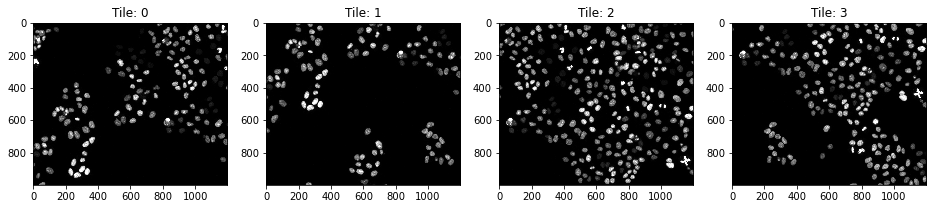

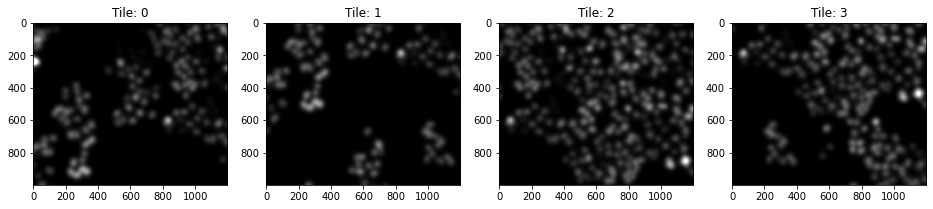

In [15]:
fig1, ax1 = plt.subplots(1, 4, figsize=(16, 8))
fig2, ax2 = plt.subplots(1, 4, figsize=(16, 8))
a = 0

# iterate over all tiles and apply the processing
for tile in tqdm(tiles):
    
    #print(tile.roi.x, tile.roi.y, tile.roi.w, tile.roi.h)

    # get a single frame based on the tile coordinates and size
    tile2d = img2d[tile.roi.y:tile.roi.y + tile.roi.h, tile.roi.x:tile.roi.x + tile.roi.w]

    # do some processing here
    tile2d_processed = process2d(tile2d, sigma=15)
    
    ax1[a].imshow(tile2d[...,0], interpolation="nearest", cmap="gray",vmin=100, vmax=2000)
    ax1[a].set_title("Tile: " + str(a))
    ax2[a].imshow(tile2d_processed[...,0], interpolation="nearest", cmap="gray",vmin=100, vmax=2000)
    ax2[a].set_title("Tile: " + str(a))

    # place frame inside the new image
    processed_img2d[tile.roi.y:tile.roi.y + tile.roi.h, tile.roi.x:tile.roi.x + tile.roi.w] = tile2d_processed
    
    a += 1

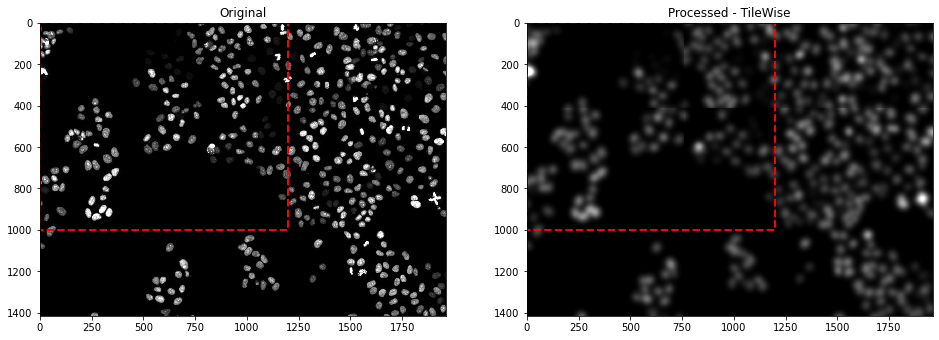

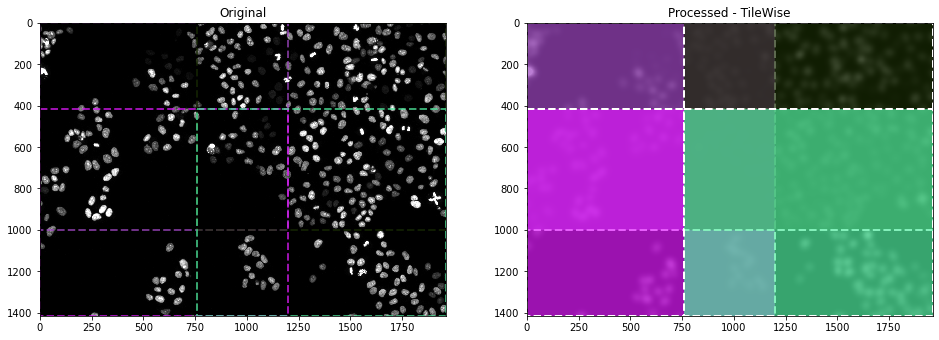

In [17]:
# show the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
ax1.imshow(img2d[...,0], interpolation="nearest", cmap="gray",vmin=100, vmax=2000)
ax1.set_title('Original')
ax2.imshow(processed_img2d[...,0], interpolation="nearest", cmap="gray",vmin=100, vmax=2000)
ax2.set_title('Processed - TileWise')

# define the tile to be shown
tn = 0
 
#add rectangle to plot
ax1.add_patch(Rectangle((tiles[tn].roi.x, tiles[tn].roi.y), tiles[tn].roi.w, tiles[tn].roi.h,
              edgecolor="red",
              fill=False,
              lw=2,
              ls="--"))

ax2.add_patch(Rectangle((tiles[tn].roi.x, tiles[tn].roi.y), tiles[tn].roi.w, tiles[tn].roi.h,
              edgecolor="red",
              fill=False,
              lw=2,
              ls="--"))

# show the results
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(16, 8))
ax3.imshow(img2d[...,0], interpolation="nearest", cmap="gray",vmin=100, vmax=2000)
ax3.set_title('Original')
ax4.imshow(processed_img2d[...,0], interpolation="nearest", cmap="gray",vmin=100, vmax=2000)
ax4.set_title('Processed - TileWise')


edge_color_opacity = 1.0
face_color_opacity = 0.7

# visualize a single tile
for tile in tiles:
    
    r = random.random()
    b = random.random()
    g = random.random()
    edgecolor = (r, g, b, face_color_opacity)
    facecolor = (r, g, b, face_color_opacity)
    
    # add rectangle to plot
    ax3.add_patch(Rectangle((tile.roi.x, tile.roi.y), tile.roi.w, tile.roi.h,
                  edgecolor=edgecolor,
                  fill=False,
                  lw=2,
                  ls="--"))

    ax4.add_patch(Rectangle((tile.roi.x, tile.roi.y), tile.roi.w, tile.roi.h,
                  edgecolor=(1, 1, 1, edge_color_opacity),
                  facecolor=facecolor,          
                  fill=True,
                  lw=2,
                  ls="--"))